# Обучим LGBM на предсобранных тренировочных данных

date = 02.02.2020


In [1]:
import gc
import os
import csv
import json
import random
import pickle
import glob
from datetime import datetime
from collections import defaultdict

import gensim
import numpy as np
import pandas as pd
import implicit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix
from tqdm import tqdm

from metrics_losses import (
    normalized_average_precision,
    average_precision
)
from utils import (
    filter_user_item_pairs,
    get_user_item_matrix,
    blend_product_lists,
    plot_lgb_feature_importance
)
from settings import(
    baseline_items,
    baseline_popular,
    check_clients
)

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
gc.enable()

%matplotlib inline

## Инкрементально обучим 7 моделей на разных чанках 02_01_3 + w2v фичи


In [2]:
lgb_params = {
    'boosting': 'gbdt',
    'objective': 'binary'#'lambdarank',
    'metric': ['auc'],
    #'eval_at': 30,
    'is_training_metric': False,
    'seed': 77,
    'learning_rate': 0.03, #0.03
    'min_data_in_leaf':500,
    'save_binary': True,
    'num_leaves': 30,
    'max_bin': 32,
    'feature_fraction': 0.7,
    'bagging_fraction': 1,
    'bagging_freq': 0,
    'lambda_l2': 1.,
    'lambda_l1': 1.,
    'num_threads': 10,
    'verbosity':-1,
}
num_trees = 120

valid_chunks = [
    '../_processed_data/train_features_02_01_3_4.tsv', 
    #'../_processed_data/train_features_02_01_3_0.tsv',
    '../_processed_data/train_features_02_01_3_15.tsv', 
    '../_processed_data/train_features_02_01_3_16.tsv', 
    '../_processed_data/train_features_02_01_3_6.tsv'
]
exclude_chunks = [
    '../_processed_data/train_features_02_01_3_20.tsv',
    '../_processed_data/train_features_02_01_3_0.tsv',
]
train_chunks = sorted(glob.glob('../_processed_data/train_features_02_01_3_*'))
train_chunks = [chunk for chunk in train_chunks 
                if chunk not in valid_chunks 
                and chunk not in exclude_chunks]
column_names = [
    'in_target_trans',
    'product_id',
    'level_1', 'level_2', 'level_3', 'level_4',
    #'segment_id', 
    'brand_id', 'vendor_id', 'netto',
    'is_own_trademark', #'is_alcohol',
    
    'product_perc', 
    'cnt_trans', 
    'client_age', #'client_gender', 
    'client_cnt_stores',
    'first_last_days_diff',
    'trans_days_diff_avg', #'trans_days_diff_std',
    'last_tr_days_diff', 'last_tr_days_ratio',
                        
    'first_last_pr_days_diff',
    'pr_days_diff_avg', 'pr_days_diff_std',
    'last_pr_days_diff', 'last_pr_days_ratio',
    
    #'trans_len_avg', 'trans_len_std', 
    'trans_sum_avg', #'trans_sum_std',
    'cnt_product_store',
    #'product_store',
    'product_perc_exp',
    'pr_cnt_in_tr_avg'
]
cat_features = ['product_id', 'level_1', 'level_2', 
                'level_3', 'level_4',
                'brand_id', 'vendor_id']

target = 'in_target_trans'
cols_to_drop = [
    'level_1',
    'client_cnt_stores',
    #'product_perc'
    #'product_id'
]
features = [col for col in column_names if col != target and col not in cols_to_drop]
cat_features = [col for col in cat_features if col != target and col not in cols_to_drop]

w2v_file = '../_model_files/w2v_01_29_2_10_20_20_2.wv'
model_w2v = gensim.models.Word2Vec.load(w2v_file)
W2V_SIZE = int(w2v_file.split('/')[-1].split('_')[-3])
w2v_features = ['w2v_' + str(i) for i in range(W2V_SIZE)]

with open('../_model_files/incremental_encoder_dict_01_23_01.pckl', 'rb') as f:
    inc_encoder = pickle.load(f)
    
prodcut_index = inc_encoder['product_id']
index_product = {v: k for k, v in prodcut_index.items()}

print(len(column_names), len(features), len(w2v_features))
print(W2V_SIZE)

27 24 20
20


In [3]:
def drop_samples(df, num_candidates1lvl=100):
    """
    If num_candidates1lvl samples doesn't have target=1 then 
    drop this num_candidates1lvl samples (one client)
    """
    target_arr = np.split(df['in_target_trans'].values, int(df.shape[0]/num_candidates1lvl))
    target_mask = [1 if sum(el)>0 else 0 for el in target_arr]
    target_train_mask = np.repeat(target_mask, num_candidates1lvl)
    df['target_train_mask'] = target_train_mask
    
    return df[df['target_train_mask'] == 1].copy()

def map_features(x):
    pr = index_product[x]
    if pr in model_w2v.wv.vocab:
        return model_w2v.wv[pr]
    else:
        return np.array([0.] * W2V_SIZE)


def get_chunks(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

train_chunks_rnd = train_chunks.copy()

random.seed(7)
random.shuffle(train_chunks_rnd)

#train_chunks_1 = train_chunks_rnd[:3]
#train_chunks_2 = train_chunks_rnd[3:6]
#train_chunks_3 = train_chunks_rnd[6:9]
#train_chunks_4 = train_chunks_rnd[9:12]
#train_chunks_5 = train_chunks_rnd[12:15]

print(len(train_chunks_rnd))

#print(len(train_chunks_1), len(train_chunks_2), len(train_chunks_3), len(train_chunks_4), len(train_chunks_5))

15


In [4]:
%%time
chunk_size = 2

for model_ind, tr_ch in enumerate(get_chunks(train_chunks_rnd[:14], chunk_size)):
    # train model
    lgb_model_cur = None

    valid = pd.read_csv(valid_chunks[0], sep='\t', names=column_names)
    # drop samples without target=1
    valid = drop_samples(valid, 100)
    
    # get w2v features
    products = valid['product_id'].values.tolist()
    w2v_df = pd.DataFrame(np.array([map_features(pr) for pr in products]), columns=w2v_features)
    valid = pd.concat([valid.reset_index(drop=True), w2v_df], axis=1)
    
    lgb_valid = lgb.Dataset(valid[features + w2v_features], 
                            label=valid[target],
                            group=np.repeat(100, int(valid.shape[0]/100)),
                            categorical_feature=cat_features, 
                            free_raw_data=False)
    #lgb_valid = lgb.Dataset(valid[features], valid[target], 
    #                        categorical_feature=cat_features, free_raw_data=False)
    for chunk in tr_ch:
        print(chunk)
        train = pd.read_csv(chunk, sep='\t', names=column_names)
        print(train.shape)
        
        # drop samples without target=1
        train = drop_samples(train, 100) 
        print(train.shape)
        
        # get w2v features
        products = train['product_id'].values.tolist()
        w2v_df = pd.DataFrame(np.array([map_features(pr) for pr in products]), columns=w2v_features)
        train = pd.concat([train.reset_index(drop=True), w2v_df], axis=1) 
        print(train[features + w2v_features].shape)
        
        lgb_train = lgb.Dataset(train[features + w2v_features], 
                                label=train[target],
                                group=np.repeat(100, int(train.shape[0]/100)),
                                categorical_feature=cat_features)
        #lgb_train = lgb.Dataset(train[features], train[target], 
        #                            categorical_feature=cat_features)

        lgb_model = lgb.train(lgb_params, lgb_train, num_trees,  
                                  valid_sets=[lgb_valid],
                                  valid_names=['valid'],
                                  #feval=nmap_lgb,
                                  verbose_eval=20,
                                  init_model=lgb_model_cur,
                                  #feature_name=features)
                                  feature_name=features + w2v_features)
        lgb_model_cur = lgb_model

        del train, lgb_train, lgb_model
        gc.collect()

        cur_aucs = []
        for valid_file in valid_chunks[1:]:
            
            valid_cur = pd.read_csv(valid_file, sep='\t', names=column_names)
            
            # drop samples without target=1
            valid_cur = drop_samples(valid_cur, 100)    
            
            # get w2v features
            products = valid_cur['product_id'].values.tolist()
            w2v_df = pd.DataFrame(np.array([map_features(pr) for pr in products]), columns=w2v_features)
            valid_cur = pd.concat([valid_cur.reset_index(drop=True), w2v_df], axis=1) 
            
            y_valid_pred = lgb_model_cur.predict(valid_cur[features + w2v_features])
            #y_valid_pred = lgb_model_cur.predict(valid_cur[features])
            
            score = roc_auc_score(valid_cur[target], y_valid_pred)
            cur_aucs.append(score)
            print(valid_file.split('/')[-1], round(score, 6))

        print('avg AUC valid: ', round(np.mean(cur_aucs), 6), '\n')        
    
    # save model
    lgb_model_cur.save_model('../_model_files/model_lgb_clsf_02_22_1_{num}.txt'.format(num=str(model_ind + 1)))
    print('*********Model saved {num} \n'.format(num=str(model_ind + 1)))

../_processed_data/train_features_02_01_3_12.tsv
(1791700, 27)
(1472200, 28)
(1472200, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.808424
[40]	valid's auc: 0.810688
[60]	valid's auc: 0.811926
[80]	valid's auc: 0.812894
[100]	valid's auc: 0.813521
[120]	valid's auc: 0.813884
train_features_02_01_3_15.tsv 0.814585
train_features_02_01_3_16.tsv 0.814978
train_features_02_01_3_6.tsv 0.814809
avg AUC valid:  0.81479 

../_processed_data/train_features_02_01_3_7.tsv
(1794900, 27)
(1469100, 28)
(1469100, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815492
[160]	valid's auc: 0.816211
[180]	valid's auc: 0.81631
[200]	valid's auc: 0.816273
[220]	valid's auc: 0.816081
[240]	valid's auc: 0.815848
train_features_02_01_3_15.tsv 0.816585
train_features_02_01_3_16.tsv 0.816237
train_features_02_01_3_6.tsv 0.815877
avg AUC valid:  0.816233 

*********Model saved 1 

../_processed_data/train_features_02_01_3_9.tsv
(1793700, 27)
(1460800, 28)
(1460800, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.809294
[40]	valid's auc: 0.810773
[60]	valid's auc: 0.811907
[80]	valid's auc: 0.813007
[100]	valid's auc: 0.813771
[120]	valid's auc: 0.81428
train_features_02_01_3_15.tsv 0.815707
train_features_02_01_3_16.tsv 0.815559
train_features_02_01_3_6.tsv 0.815735
avg AUC valid:  0.815667 

../_processed_data/train_features_02_01_3_18.tsv
(1792400, 27)
(1462000, 28)
(1462000, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815896
[160]	valid's auc: 0.816376
[180]	valid's auc: 0.816449
[200]	valid's auc: 0.816287
[220]	valid's auc: 0.815966
[240]	valid's auc: 0.815707
train_features_02_01_3_15.tsv 0.817056
train_features_02_01_3_16.tsv 0.816787
train_features_02_01_3_6.tsv 0.816333
avg AUC valid:  0.816725 

*********Model saved 2 

../_processed_data/train_features_02_01_3_5.tsv
(1792100, 27)
(1467800, 28)
(1467800, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.809143
[40]	valid's auc: 0.811036
[60]	valid's auc: 0.81197
[80]	valid's auc: 0.81317
[100]	valid's auc: 0.813793
[120]	valid's auc: 0.814284
train_features_02_01_3_15.tsv 0.815667
train_features_02_01_3_16.tsv 0.815078
train_features_02_01_3_6.tsv 0.815276
avg AUC valid:  0.81534 

../_processed_data/train_features_02_01_3_13.tsv
(1795100, 27)
(1472900, 28)
(1472900, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815804
[160]	valid's auc: 0.816328
[180]	valid's auc: 0.816316
[200]	valid's auc: 0.816162
[220]	valid's auc: 0.815922
[240]	valid's auc: 0.815625
train_features_02_01_3_15.tsv 0.816879
train_features_02_01_3_16.tsv 0.816703
train_features_02_01_3_6.tsv 0.817271
avg AUC valid:  0.816951 

*********Model saved 3 

../_processed_data/train_features_02_01_3_8.tsv
(1796400, 27)
(1467200, 28)
(1467200, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.809536
[40]	valid's auc: 0.811406
[60]	valid's auc: 0.812872
[80]	valid's auc: 0.813876
[100]	valid's auc: 0.814275
[120]	valid's auc: 0.814613
train_features_02_01_3_15.tsv 0.816159
train_features_02_01_3_16.tsv 0.815981
train_features_02_01_3_6.tsv 0.815843
avg AUC valid:  0.815994 

../_processed_data/train_features_02_01_3_2.tsv
(1796900, 27)
(1466300, 28)
(1466300, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.81609
[160]	valid's auc: 0.816539
[180]	valid's auc: 0.816423
[200]	valid's auc: 0.816215
[220]	valid's auc: 0.815904
[240]	valid's auc: 0.815532
train_features_02_01_3_15.tsv 0.816691
train_features_02_01_3_16.tsv 0.816792
train_features_02_01_3_6.tsv 0.816519
avg AUC valid:  0.816667 

*********Model saved 4 

../_processed_data/train_features_02_01_3_19.tsv
(1795000, 27)
(1472400, 28)
(1472400, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.808936
[40]	valid's auc: 0.810624
[60]	valid's auc: 0.811583
[80]	valid's auc: 0.81266
[100]	valid's auc: 0.813224
[120]	valid's auc: 0.813679
train_features_02_01_3_15.tsv 0.815028
train_features_02_01_3_16.tsv 0.814818
train_features_02_01_3_6.tsv 0.814767
avg AUC valid:  0.814871 

../_processed_data/train_features_02_01_3_10.tsv
(1792300, 27)
(1460500, 28)
(1460500, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815379
[160]	valid's auc: 0.816138
[180]	valid's auc: 0.816303
[200]	valid's auc: 0.816228
[220]	valid's auc: 0.816032
[240]	valid's auc: 0.815814
train_features_02_01_3_15.tsv 0.816642
train_features_02_01_3_16.tsv 0.816558
train_features_02_01_3_6.tsv 0.816244
avg AUC valid:  0.816481 

*********Model saved 5 

../_processed_data/train_features_02_01_3_1.tsv
(1801800, 27)
(1478200, 28)
(1478200, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.808961
[40]	valid's auc: 0.810886
[60]	valid's auc: 0.812189
[80]	valid's auc: 0.813354
[100]	valid's auc: 0.813993
[120]	valid's auc: 0.81437
train_features_02_01_3_15.tsv 0.815692
train_features_02_01_3_16.tsv 0.81561
train_features_02_01_3_6.tsv 0.81497
avg AUC valid:  0.815424 

../_processed_data/train_features_02_01_3_3.tsv
(1790300, 27)
(1467800, 28)
(1467800, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815755
[160]	valid's auc: 0.816224
[180]	valid's auc: 0.816308
[200]	valid's auc: 0.816166
[220]	valid's auc: 0.815927
[240]	valid's auc: 0.815664
train_features_02_01_3_15.tsv 0.816783
train_features_02_01_3_16.tsv 0.816448
train_features_02_01_3_6.tsv 0.815805
avg AUC valid:  0.816345 

*********Model saved 6 

../_processed_data/train_features_02_01_3_17.tsv
(1791100, 27)
(1473200, 28)
(1473200, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.80913
[40]	valid's auc: 0.810874
[60]	valid's auc: 0.812019
[80]	valid's auc: 0.813117
[100]	valid's auc: 0.813564
[120]	valid's auc: 0.814015
train_features_02_01_3_15.tsv 0.815355
train_features_02_01_3_16.tsv 0.814964
train_features_02_01_3_6.tsv 0.815175
avg AUC valid:  0.815165 

../_processed_data/train_features_02_01_3_11.tsv
(1792900, 27)
(1473000, 28)
(1473000, 44)


/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[140]	valid's auc: 0.815857
[160]	valid's auc: 0.816303
[180]	valid's auc: 0.816351
[200]	valid's auc: 0.816157
[220]	valid's auc: 0.815808
[240]	valid's auc: 0.815512
train_features_02_01_3_15.tsv 0.816712
train_features_02_01_3_16.tsv 0.816484
train_features_02_01_3_6.tsv 0.816655
avg AUC valid:  0.816617 

*********Model saved 7 

CPU times: user 1h 22min 38s, sys: 26.6 s, total: 1h 23min 4s
Wall time: 14min 1s


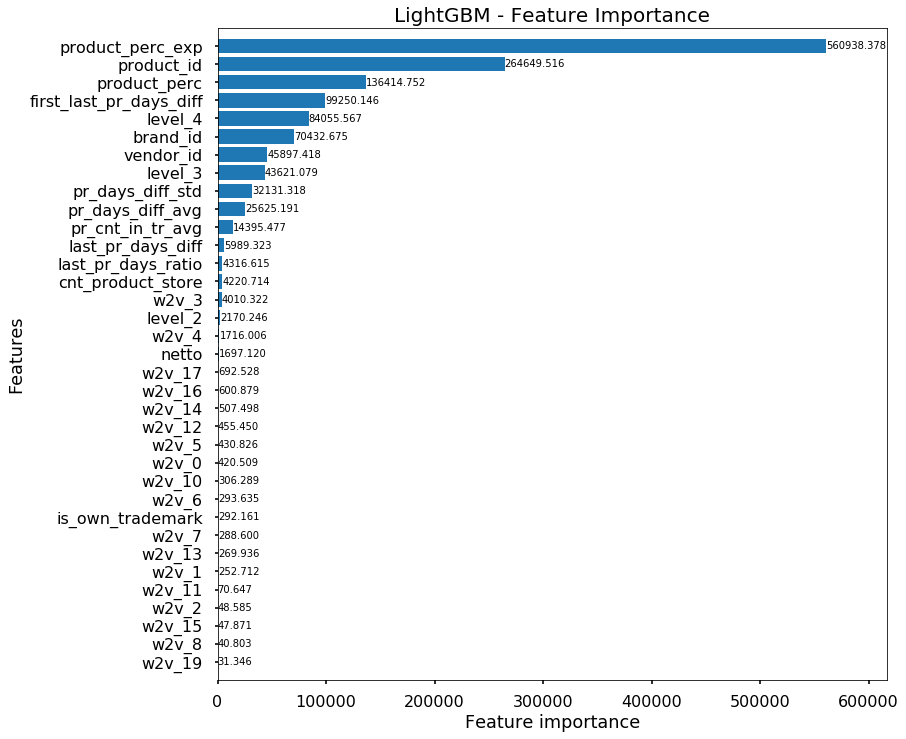

In [6]:
plot_lgb_feature_importance(lgb_model_cur, 50)

In [7]:
items_score = [(feat,score) for feat, score 
 in zip(lgb_model_cur.feature_name(), lgb_model_cur.feature_importance(importance_type='gain'))]
sorted(items_score, key=lambda x: x[1], reverse=True)

[('product_perc_exp', 560938.3781356812),
 ('product_id', 264649.5162220001),
 ('product_perc', 136414.75174713135),
 ('first_last_pr_days_diff', 99250.14596652985),
 ('level_4', 84055.56713104248),
 ('brand_id', 70432.6747264862),
 ('vendor_id', 45897.418274879456),
 ('level_3', 43621.07930183411),
 ('pr_days_diff_std', 32131.31780052185),
 ('pr_days_diff_avg', 25625.19065093994),
 ('pr_cnt_in_tr_avg', 14395.477372169495),
 ('last_pr_days_diff', 5989.323225021362),
 ('last_pr_days_ratio', 4316.6150007247925),
 ('cnt_product_store', 4220.7139892578125),
 ('w2v_3', 4010.321668624878),
 ('level_2', 2170.2459716796875),
 ('w2v_4', 1716.006121635437),
 ('netto', 1697.1198434829712),
 ('w2v_17', 692.5279846191406),
 ('w2v_16', 600.8791084289551),
 ('w2v_14', 507.49798583984375),
 ('w2v_12', 455.4495611190796),
 ('w2v_5', 430.82559967041016),
 ('w2v_0', 420.5091857910156),
 ('w2v_10', 306.2892961502075),
 ('w2v_6', 293.63459396362305),
 ('is_own_trademark', 292.1609992980957),
 ('w2v_7', 288

## Предсказываем check

In [2]:
class IncrementalEncoder():
    """
    Incremental Label Encoder for several features in row. 
    """
    def __init__(self, column_names):
        self.column_names = column_names
        self.column_indexes = {col: {} for col in self.column_names}
        self.column_ind_cur = {col: 0 for col in self.column_names}
        
    def iterate(self, row_values):
        for col, value in zip(self.column_names, row_values):
            if value not in self.column_indexes[col]:
                self.column_indexes[col][value] = self.column_ind_cur[col]
                self.column_ind_cur[col] += 1
    
    def get_column_indexers(self):
        return self.column_indexes
    
    def get_column_names(self):
        return self.column_names

    
def get_user_vector(user_products_, item_index_, user_vector_):
    user_vector = user_vector_.copy()
    
    for pr in user_products_:
        if pr in item_index_:
            user_vector[0, item_index_[pr]] = user_products_[pr]
            
    return user_vector


def get_trans_dates_features(tr_dates, target_dt_):    
    trans_days_diff = [(t - s).days for s, t in zip(tr_dates, tr_dates[1:])]
    
    first_last_days_diff = (tr_dates[-1] - tr_dates[0]).days
    trans_days_diff_avg = round(np.mean(trans_days_diff), 2)
    #trans_days_diff_std = round(np.std(trans_days_diff), 2)
    
    last_tr_days_diff = (target_dt_ - tr_dates[-1]).days
    last_tr_days_ratio = round(last_tr_days_diff/trans_days_diff_avg, 6) if trans_days_diff_avg > 0 else 0
    
    return first_last_days_diff, trans_days_diff_avg, \
        last_tr_days_diff, last_tr_days_ratio


def get_prod_dates_features(pr_dates_, target_dt_):
    if len(pr_dates_) > 1:
        pr_days_diff = [(t - s).days for s, t in zip(pr_dates_, pr_dates_[1:])]   

        first_last_pr_days_diff = (pr_dates_[-1] - pr_dates_[0]).days
        pr_days_diff_avg = round(np.mean(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0
        pr_days_diff_std = round(np.std(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0

        last_pr_days_diff = (target_dt_ - pr_dates_[-1]).days
        last_pr_days_ratio = round(last_pr_days_diff/pr_days_diff_avg, 6) if pr_days_diff_avg > 0 else 0
        
        return first_last_pr_days_diff, pr_days_diff_avg, pr_days_diff_std, \
            last_pr_days_diff, last_pr_days_ratio
    else:
        return 0, 0, 0, 0, 0

In [3]:
column_names = [
    'client_id',
    'in_target_trans',
    'product_id',
    
    'level_1', 'level_2', 'level_3', 'level_4',
    #'segment_id', 
    'brand_id', 'vendor_id', 'netto',
    'is_own_trademark', #'is_alcohol',
    
    'product_perc', 'cnt_trans', 
    'client_age', #'client_gender', 
    #'client_cnt_stores',
    'first_last_days_diff',
    'trans_days_diff_avg', #'trans_days_diff_std',
    'last_tr_days_diff', 'last_tr_days_ratio',
                        
    'first_last_pr_days_diff',
    'pr_days_diff_avg', 'pr_days_diff_std',
    'last_pr_days_diff', 'last_pr_days_ratio',
    
    #'trans_len_avg', 'trans_len_std', 
    'trans_sum_avg', #'trans_sum_std',
    #'cnt_product_store',
    'product_perc_exp',
    'pr_cnt_in_tr_avg',
    'lvl1_ind',
    
    'user_brand_perc',
    'user_brand_perc_exp',
    'user_vendor_perc',
    'user_vendor_perc_exp',
    'user_level4_perc',
    'user_level4_perc_exp',
    'user_level3_perc',
    'user_level3_perc_exp',
]
cat_features = ['product_id', 'level_1', 'level_2', 
                'level_3', 'level_4',
                'brand_id', 'vendor_id']

target = 'in_target_trans'
cols_to_drop = [
    'client_id',
    'level_1',
    'level_2',
    'user_vendor_perc_exp',
    'user_level4_perc_exp',
    'user_level3_perc_exp',
    'first_last_days_diff',
    'trans_days_diff_avg',
    'last_tr_days_diff',
    'last_tr_days_ratio',
]
features = [col for col in column_names if col != target and col not in cols_to_drop]
cat_features = [col for col in cat_features if col != target and col not in cols_to_drop]
print(len(column_names), len(features))

35 24


In [4]:
with open('../_model_files/item_index_02_01_3.pckl', 'rb') as f:
    item_index = pickle.load(f)
index_item = {v: k for k, v in item_index.items()}

with open('../_model_files/model_implicit_nn_tfidf_02_01_3.pckl', 'rb') as f:
    model_nn = pickle.load(f)
    
with open('../_model_files/incremental_encoder_01_23_01.pckl', 'rb') as f:
    inc_encoder = pickle.load(f)
    
with open('../_model_files/clients_features_01_23_01.pckl', 'rb') as f:
    clients_features = pickle.load(f)
    
with open('../_model_files/product_features_01_23_01.pckl', 'rb') as f:
    product_features = pickle.load(f)
    
w2v_file = '../_model_files/w2v_01_29_2_10_20_20_2.wv'
model_w2v = gensim.models.Word2Vec.load(w2v_file)
W2V_SIZE = int(w2v_file.split('/')[-1].split('_')[-3])
print(W2V_SIZE)

with open('../_processed_data/baseline_popular_feb.pckl', 'rb') as f:
    baseline_popular_feb = pickle.load(f)
print(len(baseline_popular_feb))

20
36670


In [5]:
def run_queries_2levels(model_nn, lgb_model, model_w2v,
                        check_file, 
                        inc_encoder, clients_features, product_features,
                        num_candidates=50):
    """
    Take implicit model and lgbm model and make recommendations
    """
    num_items = len(item_index)
    ap_values = []
    baseline_popular_feb_cur = baseline_popular_feb[:num_candidates].copy()
    
    prodcut_index = inc_encoder.get_column_indexers()['product_id']
    level1_index = inc_encoder.get_column_indexers()['level_1']
    level2_index = inc_encoder.get_column_indexers()['level_2']
    level3_index = inc_encoder.get_column_indexers()['level_3']
    level4_index = inc_encoder.get_column_indexers()['level_4']
    brand_index = inc_encoder.get_column_indexers()['brand_id']
    vendor_index = inc_encoder.get_column_indexers()['vendor_id']    
    
    with open(check_file) as fin:
        for line in tqdm(fin):
            query_data, next_transaction = line.strip().split('\t')
            query_data, next_transaction = json.loads(query_data), json.loads(next_transaction)

            transaction_history = query_data['transaction_history']
            cnt_trans = len(transaction_history)
            client_id = query_data['client_id']
            query_dt = datetime.strptime(query_data['query_time'], '%Y-%m-%dT%H:%M:%S')
            
            # age processing
            #client_age = query_data.get('age', 0)
            #if client_age < 14 or client_age > 100:
            #    client_age = 0

            # gender processing
            #client_gender = query_data.get('gender', 'U')
            #client_gender = gender_map[client_gender]
            
            if cnt_trans > 1:               
                sorted_transactions = sorted(transaction_history, 
                                             key=lambda x: datetime.strptime(x['datetime'], '%Y-%m-%dT%H:%M:%S'))
                
                last_tr_dt = datetime.strptime(sorted_transactions[-1]['datetime'], '%Y-%m-%dT%H:%M:%S')
                first_tr_dt = datetime.strptime(sorted_transactions[0]['datetime'], '%Y-%m-%dT%H:%M:%S')
                coef1 = (query_dt - first_tr_dt).days + 1
                coef2 = (query_dt - last_tr_dt).days 

                user_products = defaultdict(float)
                user_products_exp = defaultdict(float)
                #user_product_store = defaultdict(set)
                user_product_dates = defaultdict(list)
                user_product_cnt_in_tr = defaultdict(list)
                
                # brand features
                user_brand = defaultdict(float)
                #user_brand_dates = defaultdict(list)
                user_brand_exp = defaultdict(float)

                # vendor features
                user_vendor = defaultdict(float)
                #user_vendor_dates = defaultdict(list)
                #user_vendor_exp = defaultdict(float)

                # level features
                user_level4 = defaultdict(float)
                #user_level4_dates = defaultdict(list)
                #user_level4_exp = defaultdict(float)

                user_level3 = defaultdict(float)
                #user_level3_exp = defaultdict(float)
                
                user_vector = np.zeros(shape=(1, num_items), dtype=np.float32)
                purchase_sums = []
                trans_dates = []
                stores = set()
                
                for transaction in sorted_transactions:
                    purchase_sums.append(float(transaction['purchase_sum']))
                    
                    tr_dt = datetime.strptime(transaction['datetime'], '%Y-%m-%dT%H:%M:%S')
                    trans_dates.append(tr_dt)
                    
                    cur_days_diff = (query_dt - tr_dt).days
                    
                    #store_id = transaction['store_id']
                    #stores.add(store_id)
                    
                    pr_cnt_in_tr = len(transaction['products'])
                    
                    for pr in transaction['products']:
                        # for 1lvl model
                        user_products[pr['product_id']] += 1./cnt_trans
                        # for 2lvl model
                        user_products_exp[pr['product_id']] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        #user_product_store[pr['product_id']].add(store_id)
                        user_product_dates[pr['product_id']].append(tr_dt)
                        user_product_cnt_in_tr[pr['product_id']].append(pr_cnt_in_tr)
                        
                        # brand features
                        brand_id = product_features[pr['product_id']]['brand_id']
                        user_brand[brand_id] += 1./cnt_trans
                        #user_brand_dates[brand_id].append(tr_dt)
                        user_brand_exp[brand_id] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        
                        # vendor features
                        vendor_id = product_features[pr['product_id']]['vendor_id']
                        user_vendor[vendor_id] += 1./cnt_trans
                        #user_vendor_dates[vendor_id].append(tr_dt)
                        #user_vendor_exp[brand_id] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        
                        # level features
                        level4 = product_features[pr['product_id']]['level_4']
                        user_level4[level4] += 1./cnt_trans
                        #user_level4_exp[brand_id] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        
                        level3 = product_features[pr['product_id']]['level_3']
                        user_level3[level3] += 1./cnt_trans
                        #user_level3_exp[brand_id] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                
                # get dummy candidates   
                ups = sorted(user_products.items(), key=lambda x: x[1], reverse=True)
                items_ranked = [item[0] for item in ups if item[1] > 1./cnt_trans]
                
                items_ranked_set = set(items_ranked)
                rec_len = len(items_ranked)
                
                if rec_len < num_candidates:
                    items_add = [item for item in baseline_popular_feb_cur if item not in items_ranked_set]
                    candidates_dummy = items_ranked + items_add[:num_candidates - rec_len]
                else:
                    candidates_dummy = items_ranked.copy()
                
                # get model nn candidates
                user_vector = get_user_vector(user_products, item_index, user_vector)
                raw_recs = model_nn.recommend(userid=0, user_items=csr_matrix(user_vector), 
                                              N=num_candidates,
                                              filter_already_liked_items=False, recalculate_user=True)
                candidates_nn = [index_item[ind] for (ind, score) in raw_recs]
                
                # blend 1lvl models: dummy and implicit_nn_tfidf
                candidates_product = blend_product_lists(*[candidates_nn, candidates_dummy], 
                                                         num_candidates=num_candidates)   
                # features for product
                trans_sum_avg = np.mean(purchase_sums)
                #trans_sum_std = np.std(purchase_sums)       

                client_age = clients_features[client_id]['age']
                #client_gender = clients_features[client_id]['gender']
                #client_cnt_stores = len(stores)

                # trans dates features
                #first_last_days_diff, trans_days_diff_avg, \
                #    last_tr_days_diff, last_tr_days_ratio = get_trans_dates_features(trans_dates, query_dt)

                
                # collect NUM_CANDIDATES_1LEVEL rows for every client
                user_features = []

                for lvl1_ind, pr in enumerate(candidates_product):
                    if pr in product_features:
                        
                        pr_dates = user_product_dates[pr]
                        first_last_pr_days_diff, \
                                pr_days_diff_avg, \
                                pr_days_diff_std, \
                                last_pr_days_diff, \
                                last_pr_days_ratio = get_prod_dates_features(pr_dates, query_dt)
                        row_ = [
                            prodcut_index[pr],

                            #level1_index[product_features[pr]['level_1']], 
                            #level2_index[product_features[pr]['level_2']],
                            level3_index[product_features[pr]['level_3']], 
                            level4_index[product_features[pr]['level_4']],
                            #product_features[pr]['segment_id'], 
                            brand_index[product_features[pr]['brand_id']],
                            vendor_index[product_features[pr]['vendor_id']],
                            product_features[pr]['netto'],
                            product_features[pr]['is_own_trademark'], 
                            #product_features[pr]['is_alcohol'],

                            round(user_products[pr], 6), 
                            cnt_trans, 
                            client_age, 

                            #first_last_days_diff,
                            #trans_days_diff_avg, #trans_days_diff_std,
                            #last_tr_days_diff, last_tr_days_ratio,

                            first_last_pr_days_diff,
                            pr_days_diff_avg, pr_days_diff_std,
                            last_pr_days_diff, last_pr_days_ratio,

                            round(trans_sum_avg, 2), #round(trans_sum_std, 2),
                            #len(user_product_store[pr]),
                            round(user_products_exp[pr], 4),
                            round(np.mean(user_product_cnt_in_tr[pr]) if pr in user_product_cnt_in_tr else 0, 4),
                            lvl1_ind,
                            
                            # other cat features
                            round(user_brand[product_features[pr]['brand_id']], 4),
                            round(user_brand_exp[product_features[pr]['brand_id']], 4),
                            round(user_vendor[product_features[pr]['vendor_id']], 4),
                            #round(user_vendor_exp[product_features[pr]['vendor_id']], 4),
                            round(user_level4[product_features[pr]['level_4']], 4),
                            #round(user_level4_exp[product_features[pr]['level_4']], 4),
                            round(user_level3[product_features[pr]['level_3']], 4),
                            #round(user_level3_exp[product_features[pr]['level_3']], 4),
                        ]
                        #if pr in model_w2v.wv.vocab:
                        #    row_add = model_w2v.wv[pr].tolist()
                        #else:
                        #    row_add = [0.]*W2V_SIZE
                        #row_.extend(row_add)
                        user_features.append(row_)

                user_preds = lgb_model.predict(np.array(user_features))
                cand_dict = {pr:pred for pr, pred in zip(candidates_product, user_preds.tolist())}
                temp_cands = sorted(cand_dict.items(), key=lambda x: x[1], reverse=True)
                candidates_ = [x[0] for x in temp_cands][:30]

                rec_len = len(candidates_)

                if rec_len < 30:
                    items_add = [item for item in baseline_items if item not in candidates_]
                    candidates = candidates_ + items_add[:30 - rec_len]
                else:
                    candidates = candidates_.copy()
            else:
                candidates = baseline_items.copy()
                #candidates = candidates_product[:30]

            ap = normalized_average_precision(next_transaction['product_ids'], candidates)
            ap_values.append(ap)    
    
    return ap_values

In [7]:
%%time
NUM_CANDIDATES_1LEVEL = 1000
queryset_file = '../retailhero-recommender-v2/data/check_queries.tsv'
lgb_models = sorted(glob.glob('../_model_files/model_lgb_clsf_02_22_5_*'))
ap_values_all = {}

for lgb_file in lgb_models:
    lgb_m = lgb.Booster(model_file=lgb_file)
    ap_values = run_queries_2levels(model_nn, lgb_m, model_w2v,
                                queryset_file, 
                                inc_encoder, clients_features, product_features,
                                num_candidates=NUM_CANDIDATES_1LEVEL)
    print(lgb_file.split('/')[-1])
    print(sum(ap_values) / len(ap_values), '\n')
    ap_values_all[lgb_file] = ap_values

101it [00:07, 13.52it/s]
2it [00:00, 14.19it/s]

model_lgb_clsf_02_22_5_1.txt
0.13562861509497381 



101it [00:07, 13.66it/s]
0it [00:00, ?it/s]

model_lgb_clsf_02_22_5_10.txt
0.13320740930751543 



101it [00:07, 12.90it/s]
2it [00:00, 15.72it/s]

model_lgb_clsf_02_22_5_2.txt
0.13466925445130892 



101it [00:08, 12.60it/s]
0it [00:00, ?it/s]

model_lgb_clsf_02_22_5_3.txt
0.12766354638711938 



101it [00:07, 12.84it/s]
0it [00:00, ?it/s]

model_lgb_clsf_02_22_5_4.txt
0.13783723002528875 



101it [00:07, 12.83it/s]
2it [00:00, 16.45it/s]

model_lgb_clsf_02_22_5_5.txt
0.14034199520436724 



101it [00:07, 12.83it/s]
2it [00:00, 15.59it/s]

model_lgb_clsf_02_22_5_6.txt
0.13168926419509444 



101it [00:07, 12.76it/s]
2it [00:00, 16.21it/s]

model_lgb_clsf_02_22_5_7.txt
0.1291042846446409 



101it [00:08, 12.42it/s]
2it [00:00, 13.17it/s]

model_lgb_clsf_02_22_5_8.txt
0.12843516759966728 



101it [00:07, 12.64it/s]

model_lgb_clsf_02_22_5_9.txt
0.131046559707986 

CPU times: user 7min 11s, sys: 596 ms, total: 7min 12s
Wall time: 1min 18s


## Смотрим что получилось

In [8]:
valid_chunks = [
    '../_processed_data/train_features_02_22_5_4.tsv', 
    '../_processed_data/train_features_02_22_5_0.tsv',
    '../_processed_data/train_features_02_22_5_15.tsv', 
    '../_processed_data/train_features_02_22_5_16.tsv', 
    '../_processed_data/train_features_02_22_5_6.tsv'
]

exclude_chunks = [
    '../_processed_data/train_features_02_22_5_20.tsv',
    #'../_processed_data/train_features_02_01_3_0.tsv',
]
train_chunks = sorted(glob.glob('../_processed_data/train_features_02_22_5_*'))
train_chunks = [chunk for chunk in train_chunks 
                if chunk not in valid_chunks 
                and chunk not in exclude_chunks]
column_names = [
    'client_id',
    'in_target_trans',
    'product_id',
    
    #'level_1', 'level_2', 
    'level_3', 'level_4',
    #'segment_id', 
    'brand_id', 'vendor_id', 'netto',
    'is_own_trademark', #'is_alcohol',
    
    'product_perc', 'cnt_trans', 
    'client_age', #'client_gender', 
    #'client_cnt_stores',
    'first_last_days_diff',
    'trans_days_diff_avg', #'trans_days_diff_std',
    'last_tr_days_diff', 'last_tr_days_ratio',
                        
    'first_last_pr_days_diff',
    'pr_days_diff_avg', 'pr_days_diff_std',
    'last_pr_days_diff', 'last_pr_days_ratio',
    
    #'trans_len_avg', 'trans_len_std', 
    'trans_sum_avg', #'trans_sum_std',
    #'cnt_product_store',
    'product_perc_exp',
    'pr_cnt_in_tr_avg',
    'lvl1_ind',
    
    'user_brand_perc',
    'user_brand_perc_exp',
    'user_vendor_perc',
    'user_level4_perc',
    'user_level3_perc',
]

In [11]:
chunk = '../_processed_data/train_features_02_22_5_10.tsv'
train = pd.read_csv(chunk, sep='\t', names=column_names)
print(chunk)
print(train.shape)

../_processed_data/train_features_02_22_5_10.tsv
(6245600, 30)


## Проверка ансамбля на валидационных данных

In [8]:
class IncrementalEncoder():
    """
    Incremental Label Encoder for several features in row. 
    """
    def __init__(self, column_names):
        self.column_names = column_names
        self.column_indexes = {col: {} for col in self.column_names}
        self.column_ind_cur = {col: 0 for col in self.column_names}
        
    def iterate(self, row_values):
        for col, value in zip(self.column_names, row_values):
            if value not in self.column_indexes[col]:
                self.column_indexes[col][value] = self.column_ind_cur[col]
                self.column_ind_cur[col] += 1
    
    def get_column_indexers(self):
        return self.column_indexes
    
    def get_column_names(self):
        return self.column_names

    
def get_user_vector(user_products_, item_index_, user_vector_):
    user_vector = user_vector_.copy()
    
    for pr in user_products_:
        if pr in item_index_:
            user_vector[0, item_index_[pr]] = user_products_[pr]
            
    return user_vector


def get_trans_dates_features(tr_dates, target_dt_):    
    trans_days_diff = [(t - s).days for s, t in zip(tr_dates, tr_dates[1:])]
    
    first_last_days_diff = (tr_dates[-1] - tr_dates[0]).days
    trans_days_diff_avg = round(np.mean(trans_days_diff), 2)
    #trans_days_diff_std = round(np.std(trans_days_diff), 2)
    
    last_tr_days_diff = (target_dt_ - tr_dates[-1]).days
    last_tr_days_ratio = round(last_tr_days_diff/trans_days_diff_avg, 6) if trans_days_diff_avg > 0 else 0
    
    return first_last_days_diff, trans_days_diff_avg, \
        last_tr_days_diff, last_tr_days_ratio


def get_prod_dates_features(pr_dates_, target_dt_):  
    pr_days_diff = [(t - s).days for s, t in zip(pr_dates_, pr_dates_[1:])]   
    
    first_last_pr_days_diff = (pr_dates_[-1] - pr_dates_[0]).days
    pr_days_diff_avg = round(np.mean(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0
    pr_days_diff_std = round(np.std(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0
                        
    last_pr_days_diff = (target_dt_ - pr_dates_[-1]).days
    last_pr_days_ratio = round(last_pr_days_diff/pr_days_diff_avg, 6) if pr_days_diff_avg > 0 else 0
                
    
    return first_last_pr_days_diff, pr_days_diff_avg, pr_days_diff_std, \
        last_pr_days_diff, last_pr_days_ratio

In [9]:
w2v_file = '../_model_files/w2v_01_29_2_10_20_20_2.wv'
model_w2v = gensim.models.Word2Vec.load(w2v_file)
W2V_SIZE = int(w2v_file.split('/')[-1].split('_')[-3])
print(W2V_SIZE)

with open('../_model_files/item_index_02_01_3.pckl', 'rb') as f:
    item_index = pickle.load(f)
index_item = {v: k for k, v in item_index.items()}
num_items = len(item_index)

with open('../_model_files/model_implicit_nn_tfidf_02_01_3.pckl', 'rb') as f:
    model_nn = pickle.load(f)
    
with open('../_model_files/incremental_encoder_01_23_01.pckl', 'rb') as f:
    inc_encoder = pickle.load(f)
    
with open('../_model_files/clients_features_01_23_01.pckl', 'rb') as f:
    clients_features = pickle.load(f)
    
with open('../_model_files/product_features_01_23_01.pckl', 'rb') as f:
    product_features = pickle.load(f)
    
with open('../_processed_data/products_fresh_feb_5.pckl', 'rb') as f:
    fresh_items = pickle.load(f)

prodcut_index = inc_encoder.get_column_indexers()['product_id']
level1_index = inc_encoder.get_column_indexers()['level_1']
level2_index = inc_encoder.get_column_indexers()['level_2']
level3_index = inc_encoder.get_column_indexers()['level_3']
level4_index = inc_encoder.get_column_indexers()['level_4']
brand_index = inc_encoder.get_column_indexers()['brand_id']
vendor_index = inc_encoder.get_column_indexers()['vendor_id'] 

20


In [10]:
def run_queries_ensemble(model_nn, lgb_models, model_w2v,
                        check_file,
                        num_candidates=100):
    """
    Take implicit model and 3 lgbm models and make recommendations
    """
    ap_values = [] 
    
    with open(check_file) as fin:
        for line in tqdm(fin):
            query_data, next_transaction = line.strip().split('\t')
            query_data, next_transaction = json.loads(query_data), json.loads(next_transaction)

            transaction_history = query_data['transaction_history']
            cnt_trans = len(transaction_history)
            client_id = query_data['client_id']
            query_dt = datetime.strptime(query_data['query_time'], '%Y-%m-%dT%H:%M:%S')
            
            # age processing
            #client_age = query_data.get('age', 0)
            #if client_age < 14 or client_age > 100:
            #    client_age = 0

            # gender processing
            #client_gender = query_data.get('gender', 'U')
            #client_gender = gender_map[client_gender]
            
            if cnt_trans > 1:               
                sorted_transactions = sorted(transaction_history, 
                                             key=lambda x: datetime.strptime(x['datetime'], '%Y-%m-%dT%H:%M:%S'))
                
                last_tr_dt = datetime.strptime(sorted_transactions[-1]['datetime'], '%Y-%m-%dT%H:%M:%S')
                first_tr_dt = datetime.strptime(sorted_transactions[0]['datetime'], '%Y-%m-%dT%H:%M:%S')
                coef1 = (query_dt - first_tr_dt).days + 1
                coef2 = (query_dt - last_tr_dt).days 

                user_products = defaultdict(float)
                user_products_exp = defaultdict(float)
                user_product_store = defaultdict(set)
                user_product_dates = defaultdict(list)
                user_product_cnt_in_tr = defaultdict(list)
                
                user_vector = np.zeros(shape=(1, num_items), dtype=np.float32)
                purchase_sums = []
                trans_dates = []
                stores = set()
                
                for transaction in sorted_transactions:
                    purchase_sums.append(float(transaction['purchase_sum']))
                    
                    tr_dt = datetime.strptime(transaction['datetime'], '%Y-%m-%dT%H:%M:%S')
                    trans_dates.append(tr_dt)
                    
                    cur_days_diff = (query_dt - tr_dt).days
                    
                    store_id = transaction['store_id']
                    stores.add(store_id)
                    
                    pr_cnt_in_tr = len(transaction['products'])
                    
                    for pr in transaction['products']:
                        # for 1lvl model
                        user_products[pr['product_id']] += 1./cnt_trans
                        # for 2lvl model
                        user_products_exp[pr['product_id']] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        user_product_store[pr['product_id']].add(store_id)
                        user_product_dates[pr['product_id']].append(tr_dt)
                        user_product_cnt_in_tr[pr['product_id']].append(pr_cnt_in_tr)
                
                # get dummy candidates   
                ups = sorted(user_products.items(), key=lambda x: x[1], reverse=True)
                items_ranked = [item[0] for item in ups if item[1] > 1./cnt_trans]
                
                items_ranked_set = set(items_ranked)
                rec_len = len(items_ranked)
                
                if rec_len < num_candidates:
                    items_add = [item for item in baseline_popular if item not in items_ranked_set]
                    candidates_dummy = items_ranked + items_add[:num_candidates - rec_len]
                else:
                    candidates_dummy = items_ranked.copy()
                
                # get model nn candidates
                user_vector = get_user_vector(user_products, item_index, user_vector)
                raw_recs = model_nn.recommend(userid=0, user_items=csr_matrix(user_vector), 
                                              N=NUM_CANDIDATES_1LEVEL,
                                              filter_already_liked_items=False, recalculate_user=True)
                candidates_nn = [index_item[ind] for (ind, score) in raw_recs]
                
                # blend 1lvl models: dummy and implicit_nn_tfidf
                candidates_product = blend_product_lists(*[candidates_nn, candidates_dummy], 
                                                         num_candidates=num_candidates)   
                # features for product
                trans_sum_avg = np.mean(purchase_sums)
                #trans_sum_std = np.std(purchase_sums)       

                client_age = clients_features[client_id]['age']
                client_gender = clients_features[client_id]['gender']
                client_cnt_stores = len(stores)

                # trans dates features
                first_last_days_diff, trans_days_diff_avg, \
                    last_tr_days_diff, last_tr_days_ratio = get_trans_dates_features(trans_dates, query_dt)

                
                # collect NUM_CANDIDATES_1LEVEL rows for every client
                user_features = []

                for pr in candidates_product:
                    if pr in product_features:
                        
                        pr_dates = user_product_dates[pr]
                        len_pr_dates = len(pr_dates)
                        
                        if len_pr_dates > 1:
                            first_last_pr_days_diff, \
                                pr_days_diff_avg, \
                                pr_days_diff_std, \
                                last_pr_days_diff, \
                                last_pr_days_ratio = get_prod_dates_features(pr_dates, query_dt)
                        else:
                            first_last_pr_days_diff = 0
                            pr_days_diff_avg = 0
                            pr_days_diff_std = 0

                            last_pr_days_diff = 0
                            last_pr_days_ratio = 0
                        row_ = [
                                prodcut_index[pr], 

                                level1_index[product_features[pr]['level_1']], 
                                level2_index[product_features[pr]['level_2']],
                                level3_index[product_features[pr]['level_3']], 
                                level4_index[product_features[pr]['level_4']],
                                #product_features[pr]['segment_id'], 
                                brand_index[product_features[pr]['brand_id']],
                                vendor_index[product_features[pr]['vendor_id']],
                                product_features[pr]['netto'],
                                product_features[pr]['is_own_trademark'], 
                                #product_features[pr]['is_alcohol'],

                                round(user_products[pr], 6), 
                                cnt_trans, 
                                client_age, 
                                #client_gender,
                                client_cnt_stores,

                                first_last_days_diff,
                                trans_days_diff_avg, #trans_days_diff_std,
                                last_tr_days_diff, last_tr_days_ratio,

                                first_last_pr_days_diff,
                                pr_days_diff_avg, pr_days_diff_std,
                                last_pr_days_diff, last_pr_days_ratio,

                                #trans_len_avg, trans_len_std, 
                                round(trans_sum_avg, 2), #round(trans_sum_std, 2),
                                len(user_product_store[pr]),
                                round(user_products_exp[pr], 6),
                                np.mean(user_product_cnt_in_tr[pr]) if pr in user_product_cnt_in_tr else 0,
                        ]
                        if pr in model_w2v.wv.vocab:
                            row_add = model_w2v.wv[pr].tolist()
                        else:
                            row_add = [0.]*W2V_SIZE
                        row_.extend(row_add)
                        user_features.append(row_)
                
                user_preds = [lgb_model.predict(np.array(user_features)) for lgb_model in lgb_models]
                candidates_ = []
                
                for user_pred in user_preds:
                    cand_dict = {pr: pred for pr, pred in zip(candidates_product, user_pred.tolist())}
                    temp_cands = sorted(cand_dict.items(), key=lambda x: x[1], reverse=True)
                    candidates_.append([x[0] for x in temp_cands])

                candidates_ = blend_product_lists(*candidates_, num_candidates=100)
                # delete outdated items
                candidates_ = [item for item in candidates_ if item in fresh_items]
                candidates_ = candidates_[:30].copy()
                candidates_set = set(candidates_)

                rec_len = len(candidates_)

                if rec_len < 30:
                    items_add = [item for item in baseline_items if item not in candidates_]
                    candidates = candidates_ + items_add[:30 - rec_len]
                else:
                    candidates = candidates_.copy()
            else:
                candidates = baseline_items.copy()
                #candidates = candidates_product[:30]

            ap = normalized_average_precision(next_transaction['product_ids'], candidates)
            ap_values.append(ap)    
    
    return ap_values

### Ансамбль на check

In [12]:
%%time
NUM_CANDIDATES_1LEVEL = 100
queryset_file = '../retailhero-recommender-v2/data/check_queries.tsv'
# lgb models
lgb_models = [
    '../_model_files/model_lgb_clsf_02_22_1_3.txt',
    '../_model_files/model_lgb_clsf_02_22_1_5.txt',
    '../_model_files/model_lgb_clsf_02_22_1_7.txt'
]
lgb_models = [lgb.Booster(model_file=lgb_file) for lgb_file in lgb_models]
model_w2v = gensim.models.Word2Vec.load('../_model_files/w2v_01_29_2_10_20_20_2.wv')
ap_values = run_queries_ensemble(model_nn, lgb_models, model_w2v,
                                 queryset_file,
                                 num_candidates=NUM_CANDIDATES_1LEVEL)
print(sum(ap_values) / len(ap_values))

101it [00:00, 102.69it/s]

0.14186230174960454
CPU times: user 12.2 s, sys: 26.8 ms, total: 12.3 s
Wall time: 1.22 s


### Ансамбль на валидационных фолдах

In [6]:
%%time
valid_chunks = [
    '../_processed_data/client_tr_history_4.tsv', 
    '../_processed_data/client_tr_history_0.tsv',
    '../_processed_data/client_tr_history_15.tsv', 
    '../_processed_data/client_tr_history_16.tsv', 
    '../_processed_data/client_tr_history_6.tsv'
]
NUM_CANDIDATES_1LEVEL = 100
# lgb models
lgb_models = [
    '../_model_files/model_lgb_clsf_02_02_4_3.txt',
    '../_model_files/model_lgb_clsf_02_02_4_4.txt',
    '../_model_files/model_lgb_clsf_02_02_4_5.txt'
]
lgb_models = [lgb.Booster(model_file=lgb_file) for lgb_file in lgb_models]
model_w2v = gensim.models.Word2Vec.load('../_model_files/w2v_01_29_2_10_20_20_2.wv')
scores = [] 

for chunk_file in valid_chunks:
    ind = chunk_file.split('_')[-1].split('.')[0]
    valid_file_name = '../retailhero-recommender-v2/data/check_queries_02_01_{num}.tsv'.format(num=ind)

    ap_values = run_queries_ensemble(model_nn, lgb_models, model_w2v,
                                     valid_file_name,
                                     num_candidates=NUM_CANDIDATES_1LEVEL)
    score = sum(ap_values) / len(ap_values)
    scores.append(score)
    
    print(valid_file_name)
    print(round(score, 6), '\n')

print('*********************')
print('Avg score:', round(np.mean(scores), 6))

18877it [03:23, 92.58it/s] 
9it [00:00, 86.87it/s]

../retailhero-recommender-v2/data/check_queries_02_01_4.tsv
0.145955 



18773it [03:26, 90.99it/s] 
11it [00:00, 103.22it/s]

../retailhero-recommender-v2/data/check_queries_02_01_0.tsv
0.142993 



18918it [03:45, 83.77it/s] 
7it [00:00, 65.08it/s]

../retailhero-recommender-v2/data/check_queries_02_01_15.tsv
0.145122 



18883it [03:26, 91.30it/s] 
9it [00:00, 78.85it/s]

../retailhero-recommender-v2/data/check_queries_02_01_16.tsv
0.145158 



18904it [03:11, 98.89it/s] 

../retailhero-recommender-v2/data/check_queries_02_01_6.tsv
0.145215 

*********************
Avg score: 0.144889
CPU times: user 3h 16min 20s, sys: 10.3 s, total: 3h 16min 30s
Wall time: 17min 14s
